In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
nltk.download('punkt')
sns.set(style="whitegrid")

[nltk_data] Downloading package punkt to /Users/hamimc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
# so here, I originally wanted to try and go through the entire 2GB CSV file. And that was not a smart idea, it took too long and didn't
# complete the job, my computer began to overheat too. So I went on Stackoverflow and found that the best method was to load the data in
# chunks. I initially did 100k but it was too long, then 75k, and 50k seems to be the best while incorporating the most data. 
# https://stackoverflow.com/questions/61393542/reading-a-huge-csv-file-in-jupyter-notebook. 

# So what I did was set the chunksize to 50,000. And I included only 2 of them, so 100,000 rows for every visualization that I chose. 
# TOTAL TIME TO GO THROUGH ALL 7 CELLS HERE: 476 SECONDS. 

FILE = "data.csv"
CHUNKSIZE = 50000

chunks = pd.read_csv(FILE, chunksize=CHUNKSIZE)
first2_chunks = []

for i, chunk in enumerate(chunks):
    if i < 2:
        first2_chunks.append(chunk)

df_first2 = pd.concat(first2_chunks, ignore_index=True)
print("Rows loaded from first 2 chunks:", len(df_first2))

Rows loaded from first 2 chunks: 100000


In [34]:
# This is me filtering. In the assignment description, it says that I have to filter texts where source == "gpt-3.5"

gpt = df_first2[df_first2['source'].astype(str).str.lower() == 'gpt-3.5'].copy()
print("GPT-3.5 rows in first 2 chunks:", len(gpt))

GPT-3.5 rows in first 2 chunks: 20434


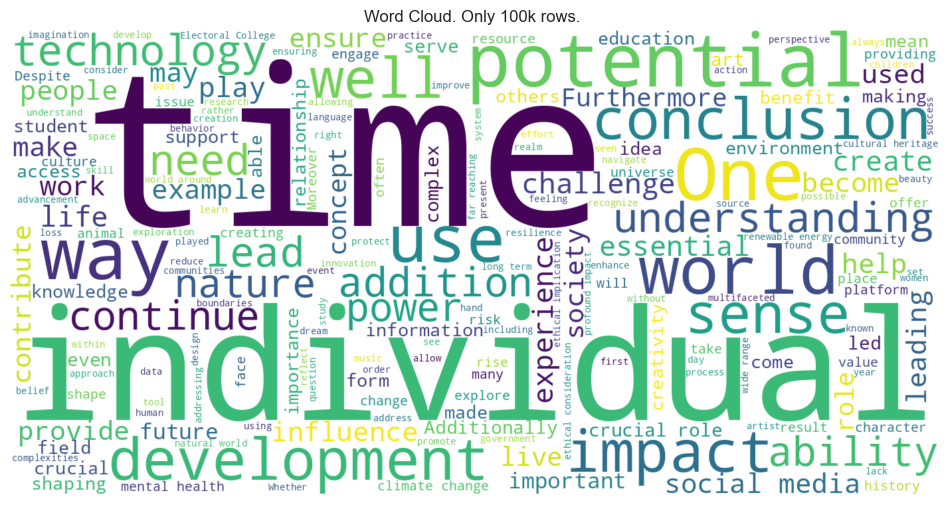

In [35]:
# Here, making the word cloud. I honestly never knew how to make a word cloud but it seemed cool, and I used this website for help
# https://www.datacamp.com/tutorial/wordcloud-python

text_all = " ".join(gpt["text"].astype(str))
wc = WordCloud(
    width=1400,
    height=700,
    background_color="white",
    stopwords=STOPWORDS,
).generate(text_all)

plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud. Only 100k rows. ")
plt.show()

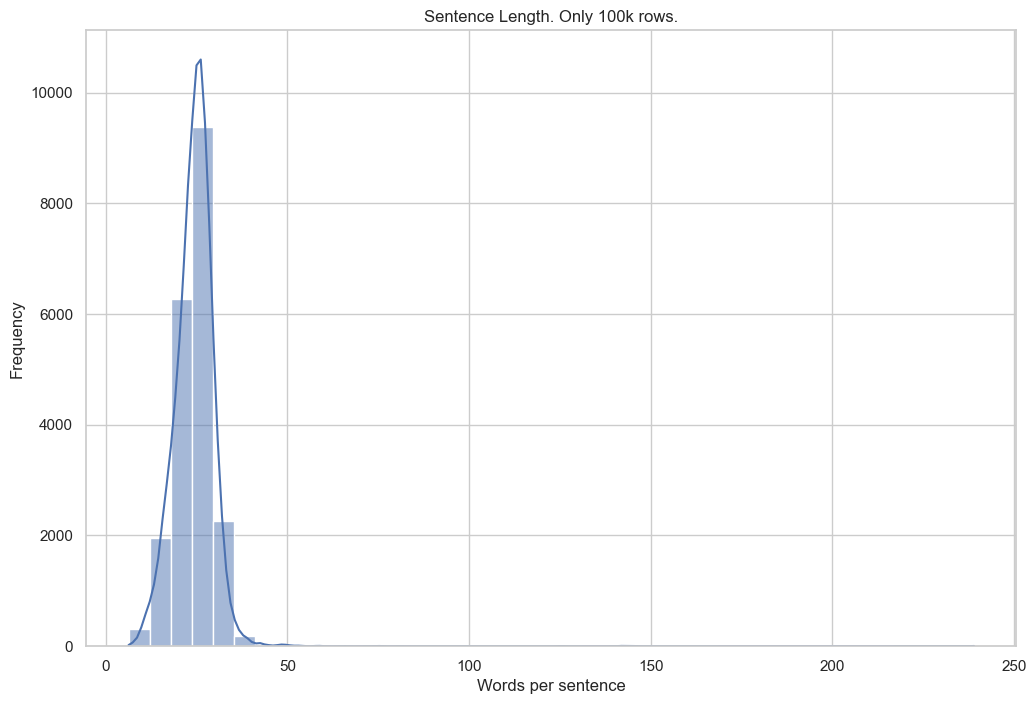

In [36]:
# this is the average sentence length for each row. and i made a histogram plot for it. 

def avg_sent_len(text):
    sents = sent_tokenize(str(text))
    if not sents:
        return 0
    return np.mean([len(word_tokenize(s)) for s in sents])
gpt['avg_sentence_length'] = gpt['text'].apply(avg_sent_len)

plt.figure(figsize=(12,8))
sns.histplot(gpt['avg_sentence_length'], bins=40, kde=True)
plt.title("Sentence Length. Only 100k rows.")
plt.xlabel("Words per sentence")
plt.ylabel("Frequency")
plt.show()

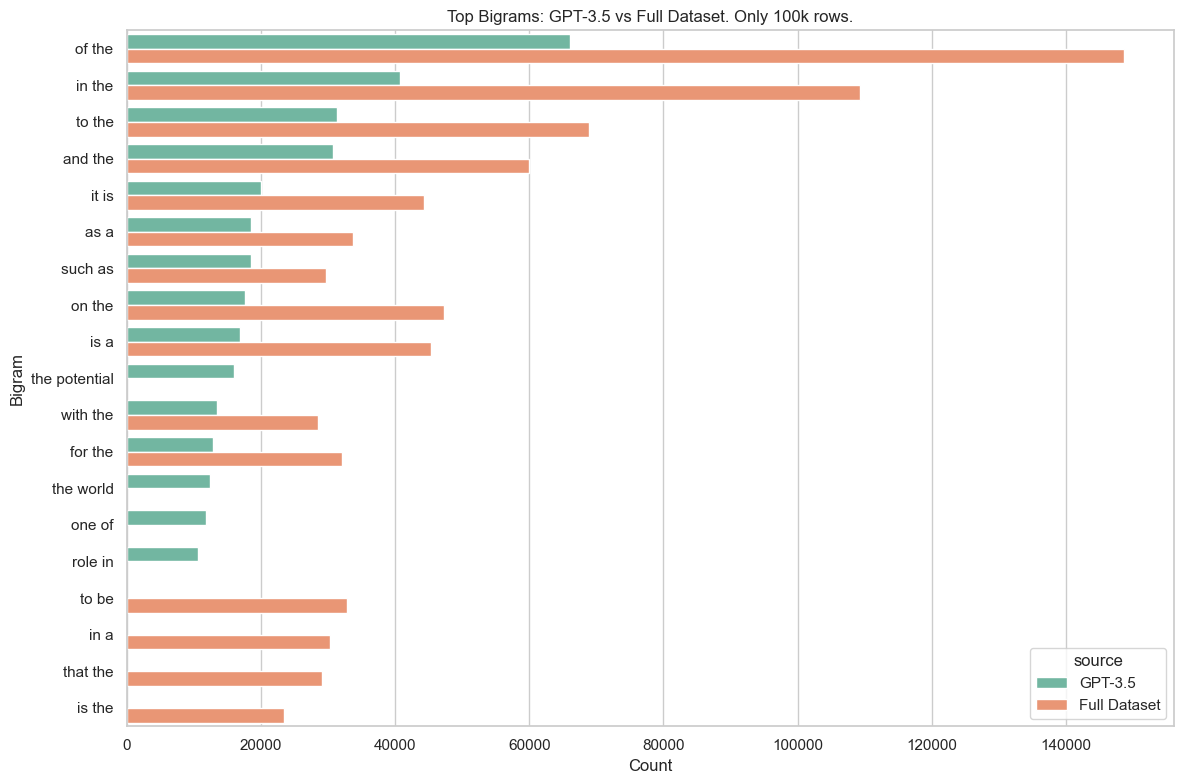

In [37]:
def extract_bigrams(texts):
    big = Counter()
    for t in texts:
        tokens = [w.lower() for w in word_tokenize(str(t)) if re.match(r"[a-zA-Z]", w)]
        for i in range(len(tokens)-1):
            big[(tokens[i], tokens[i+1])] += 1
    return big

#gpt-3.5 bigrams
gpt_bigrams = extract_bigrams(gpt["text"])

#the dataset bigrams of the first 100k rows
full_bigrams = extract_bigrams(df_first2["text"])

#top 15 bigrams
gpt_top = gpt_bigrams.most_common(15)
full_top = full_bigrams.most_common(15)
compare_df = pd.DataFrame({
    "bigram": [" ".join(w) for w, c in gpt_top + full_top],
    "count": [c for w, c in gpt_top + full_top],
    "source": ["GPT-3.5"]*15 + ["Full Dataset"]*15
})

plt.figure(figsize=(12,8))
sns.barplot(
    data=compare_df,
    y="bigram",
    x="count",
    hue="source",
    palette="Set2"
)
plt.title("Top Bigrams: GPT-3.5 vs Full Dataset. Only 100k rows.")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()